<a href="https://colab.research.google.com/github/BillWorstell/DiffDRR/blob/main/CheckWideFOV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ic| camera_idx: 0
ic| camera_idx: 1
ic| camera_idx: 2
ic| camera_idx: 3
ic| camera_idx: 4
ic| camera_idx: 5
ic| camera_idx: 6
ic| camera_idx: 7
ic| camera_idx: 8
ic| camera_idx: 9
ic| camera_idx: 10
ic| camera_idx: 11
ic| camera_idx: 12
ic| camera_idx: 13
ic| camera_idx: 14
ic| camera_idx: 15
ic| camera_idx: 16
ic| camera_idx: 17
ic| camera_idx: 18
ic| camera_idx: 19
ic| camera_idx: 20
ic| camera_idx: 21
ic| camera_idx: 22
ic| camera_idx: 23
ic| camera_idx: 24
ic| camera_idx: 25
ic| camera_idx: 26
ic| camera_idx: 27
ic| camera_idx: 28
ic| camera_idx: 29
ic| camera_idx: 30
ic| camera_idx: 31
ic| camera_idx: 32
ic| camera_idx: 33
ic| camera_idx: 34
ic| camera_idx: 35
ic| camera_idx: 36
ic| camera_idx: 37
ic| camera_idx: 38
ic| camera_idx: 39
ic| camera_idx: 40
ic| camera_idx: 41
ic| camera_idx: 42
ic| camera_idx: 43
ic| camera_idx: 44
ic| camera_idx: 45
ic| camera_idx: 46
ic| camera_idx: 47
ic| camera_idx: 48
ic| camera_idx: 49
ic| camera_idx: 50
ic| camera_idx: 51
ic| camera_idx: 52
ic|

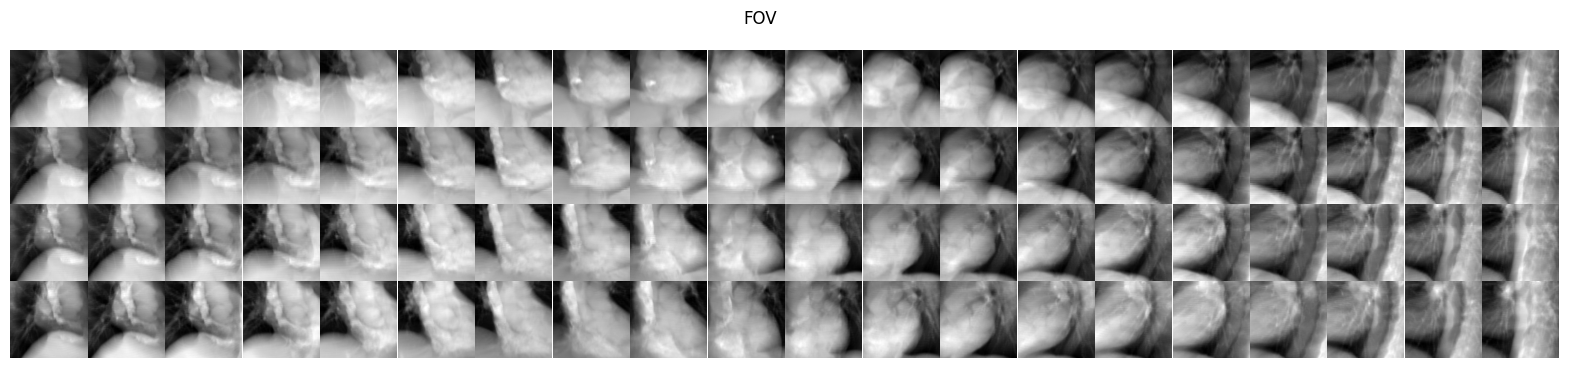

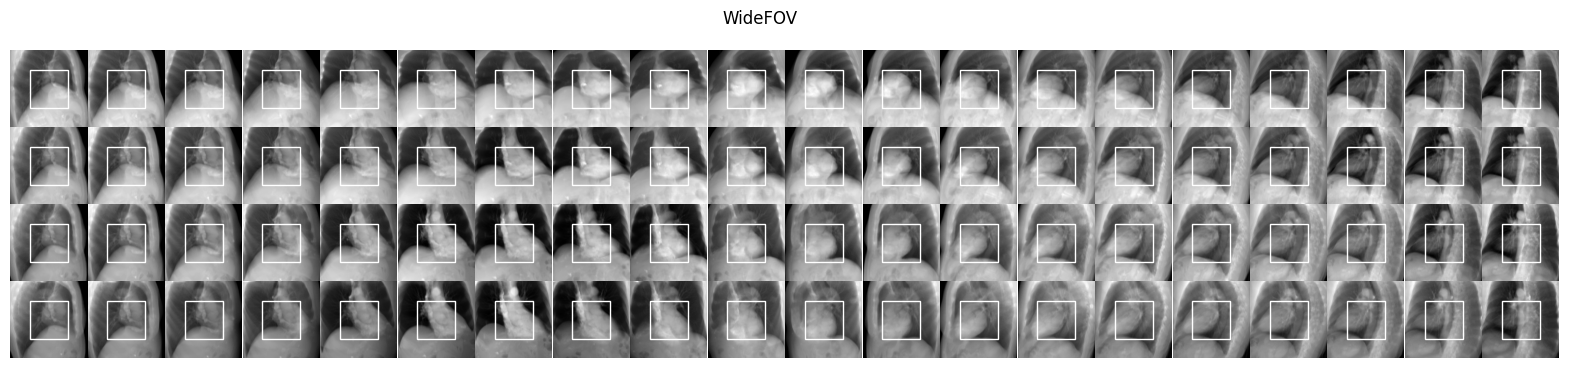

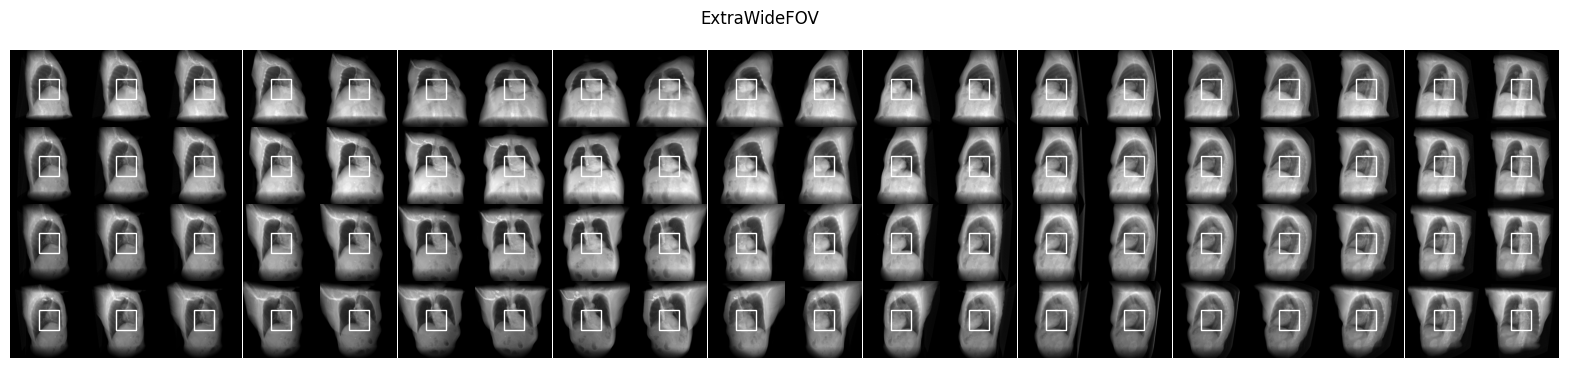

In [3]:
# Install the diffdrr and icecream packages
!pip install diffdrr icecream

import matplotlib.pyplot as plt
import torch
import numpy as np
from google.colab import drive
from openpyxl import load_workbook
from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr
from icecream import ic

# Read in the volume and get its origin and spacing in world coordinates
subject = load_example_ct()

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mount Google Drive
drive.mount('/content/drive')

# Path to the spreadsheet containing the camera geometry specifications
spreadsheet_path = '/content/drive/MyDrive/SPECTGeometry/MDSL.excel80M10RFR.cut-plate.008.150roi.2.30pin.105ellipse.xlsx'

# Load the workbook and select the appropriate worksheet
wb = load_workbook(filename=spreadsheet_path, data_only=True)
wb.active = 1  # Assuming the relevant sheet is the second one (index 1)
ws = wb.active

# Read lcoll values from the spreadsheet
lcoll = np.array([ws.cell(row=i, column=7).value for i in range(3, 83)])
vsdr = 5. * lcoll  # Example operation on lcoll values

# Read alpha and beta values from the spreadsheet (in radians)
alpha = [ws.cell(row=i, column=22).value - (np.pi/2.) for i in range(3, 83)]
beta = [ws.cell(row=i, column=23).value for i in range(3, 83)]

# Define parameters for DRR generation
HEIGHT = 250
DELX = 1.0

# Initialize the projections array for Wide and FOV cases
projections = np.zeros((80, 250, 250))

# Generate DRRs for all 80 cameras with DELX=1.0
for camera_idx in range(80):
    SDR = float(vsdr[camera_idx])
    true_params = {
        "sdr": SDR,
        "alpha": alpha[camera_idx],
        "beta": beta[camera_idx],
        "gamma": 0.0,
        "bx": 0.,
        "by": float(vsdr[camera_idx]),
        "bz": 0.,
    }
    device = "cuda" if torch.cuda.is_available() else "cpu"
    drr = DRR(subject, sdd=SDR, height=HEIGHT, delx=DELX).to(device)
    rotations = torch.tensor(
      [
        [
            true_params["alpha"],
            true_params["beta"],
            true_params["gamma"],
        ]
      ]
    ).to(device)
    translations = torch.tensor(
      [
        [
            true_params["bx"],
            true_params["by"],
            true_params["bz"],
        ]
      ]
    ).to(device)
    ground_truth = drr(
        rotations,
        translations,
        parameterization="euler_angles",
        convention="ZXY",
    )
    ic(camera_idx)
    projections[camera_idx, :, :] = ground_truth.squeeze().cpu().numpy()

# Initialize the projections array for ExtraWide case
projections_extra_wide = np.zeros((80, 250, 250))

# Generate DRRs for all 80 cameras with DELX=2.0
for camera_idx in range(80):
    SDD = float(vsdr[camera_idx]) # 10x scale for 50mm x 50mm at lcol
    true_params = {
        "sdd": SDD,
        "alpha": alpha[camera_idx],
        "beta": beta[camera_idx],
        "gamma": 0.0,
        "bx": 0.,
        "by": float(vsdr[camera_idx]),
        "bz": 0.,
    }
    device = "cuda" if torch.cuda.is_available() else "cpu"
    drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=2.0).to(device)
    drr_wide= DRR(subject, sdd=SDD, height=HEIGHT, delx=4.0).to(device)
    rotations = torch.tensor(
      [
        [
            true_params["alpha"],
            true_params["beta"],
            true_params["gamma"],
        ]
      ]
    ).to(device)
    translations = torch.tensor(
      [
        [
            true_params["bx"],
            true_params["by"],
            true_params["bz"],
        ]
      ]
    ).to(device)
    ground_truth = drr(
        rotations,
        translations,
        parameterization="euler_angles",
        convention="ZXY",
    )
    ic(camera_idx)
    projections_extra_wide[camera_idx, :, :] = ground_truth.squeeze().cpu().numpy()

# Function to add a white box overlay
def add_fov_box(ax, width, height):
    rect = plt.Rectangle((125 - width // 2, 125 - height // 2), width, height, linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(rect)

# Display central 128x128 pixels (FOV)
fig, axes = plt.subplots(nrows=4, ncols=20, figsize=(20, 4), gridspec_kw={'wspace': 0, 'hspace': 0})
for i, ax in enumerate(axes.flat):
    ax.imshow(projections[i][61:189, 61:189], cmap='gray')
    ax.axis('off')
plt.suptitle('FOV')
plt.show()

# Display projections with WideFOV
fig, axes = plt.subplots(nrows=4, ncols=20, figsize=(20, 4), gridspec_kw={'wspace': 0, 'hspace': 0})
for i, ax in enumerate(axes.flat):
    ax.imshow(projections[i], cmap='gray')
    add_fov_box(ax, 124, 124)  # Central 124x124 pixels
    ax.axis('off')
plt.suptitle('WideFOV')
plt.show()

# Display projections with ExtraWideFOV
fig, axes = plt.subplots(nrows=4, ncols=20, figsize=(20, 4), gridspec_kw={'wspace': 0, 'hspace': 0})
for i, ax in enumerate(axes.flat):
    ax.imshow(projections_extra_wide[i], cmap='gray')
    add_fov_box(ax, 64, 64)  # Central 64x64 pixels
    ax.axis('off')
plt.suptitle('ExtraWideFOV')
plt.show()
